In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import os
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Step 1 : Setting Companies and Price Data

### Universal, historical S&P 500 compositions.
Get all companies that have been included in the S&P 500 index at any point since the year 2000, including those that have been delisted. Since the components of the S&P 500 change over time, backtesting will take into account the historical changes in its constituents.


### The daily price of Universal tickers and SPX
Get daily stock prices(Adjusted Closing Price) for 1,213 companies included in the universal S&P Index and the SPX Index since 2000, including prices of those that have been delisted.
This is from Bloomberg and Yahoo.  


### Survivorship bias
To eliminate survivorship bias, a common mistake in investment strategy analysis, we downloaded the list of delisted companies along with their historical stock prices to enhance the effectiveness of the strategy

In [5]:
unique_tickers = pd.read_excel('unique_ticker_list_1213.xlsx', index_col=0).set_index('unique_ticker')['Ticker_Code'].to_frame()
historical_tickers = pd.read_excel('spx_history_since2000.xlsx', index_col=0)

daily_price = pd.read_excel("daily_price.xlsx", index_col=0)
daily_spx = yf.download("^GSPC", start="2000-01-04", end="2024-09-30", interval='1d')['Adj Close'].to_frame('SP500')

daily_price.index = daily_price.index.tz_localize(None)
daily_price = daily_price.dropna(axis=1, how='all')
daily_price = daily_price.loc[daily_price.index.isin(daily_spx.index)]

[*********************100%***********************]  1 of 1 completed


In [19]:
daily_price

,AAMRQ UN Equity,LEG UN Equity,653707Q UN Equity,LLY UN Equity,3277Q UN Equity,CAR UN Equity,BBWI UN Equity,0202445Q UN Equity,LNC UN Equity,L UN Equity,...,DECK UN Equity,DOC US Equity,SMCI UW Equity,GEV UN Equity,KKR UN Equity,LH UN Equity,SOLV UN Equity,VST UN Equity,CRWD UW Equity,GDDY UN Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-04,29.4593,7.7343,68.1737,31.6539,113.1114,26.8803,5.4020,32.3261,19.6128,8.190,...,NaN,2.4483,NaN,NaN,NaN,7.2822,NaN,NaN,NaN,NaN
2000-01-05,28.5370,7.7343,67.5932,32.2814,114.8215,26.2300,5.3256,32.1629,18.9343,8.138,...,NaN,2.4932,NaN,NaN,NaN,7.2822,NaN,NaN,NaN,NaN
2000-01-06,27.8103,7.7095,65.1880,33.2225,119.2800,26.8081,5.2406,31.8908,19.2808,8.085,...,NaN,2.5829,NaN,NaN,NaN,7.1521,NaN,NaN,NaN,NaN
2000-01-07,28.4811,7.8335,64.7733,35.6695,120.0129,27.6752,5.2746,31.9996,19.7693,8.216,...,NaN,2.6406,NaN,NaN,NaN,7.4122,NaN,NaN,NaN,NaN
2000-01-10,29.4314,7.8087,67.4273,34.2578,117.5699,25.7242,5.2066,32.5438,19.8019,8.172,...,NaN,2.6534,NaN,NaN,NaN,7.2822,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,0.2400,13.0000,20.3500,918.5200,44.0000,86.6300,30.3400,106.9500,32.0200,78.670,...,154.21,22.5700,465.94,251.53,132.60,224.7200,70.12,111.63,293.14,158.53
2024-09-24,0.2400,13.7200,20.3500,924.4300,44.0000,87.2000,30.0700,106.9500,31.2900,78.160,...,154.40,22.7700,463.61,255.48,132.39,220.6000,70.04,112.40,288.54,157.77
2024-09-25,0.2400,13.2300,20.3500,924.5600,44.0000,82.4600,30.5300,106.9500,30.8300,78.060,...,154.50,22.8000,458.15,255.05,131.67,218.6100,69.22,119.08,286.47,158.81


# Step 2: Get Factors
the quarterly cash dividend amounts and share repurchase amounts for 1,213 universal S&P index companies since the end of 1999.

In [7]:
factors = pd.read_excel("peter_v4_1213.xlsx",index_col=0, header=[0, 1])
factors = factors[:-2].copy()
# factors = factors.loc[factors.index >= '2013-12-01']

# modify factor
factor_1 = factors.xs('CF_DECR_CAP_STOCK', level=1, axis=1) / factors.xs('CF_DVD_PAID', level=1, axis=1)
factor_2 = factors.xs('CF_DECR_CAP_STOCK', level=1, axis=1) - factors.xs('CF_DVD_PAID', level=1, axis=1)

for first_level in factors.columns.get_level_values(0).unique():
    factors[(first_level, 'Buyback/Cashdividend')] = factor_1[first_level]
for first_level in factors.columns.get_level_values(0).unique():
    factors[(first_level, 'Buyback-Cashdividend')] = factor_2[first_level]
factors_sorted = factors.sort_index(axis=1, level=0)
factors_sorted.to_excel("New_factors.xlsx")
factors_sorted.to_pickle('New_factors.pickle')

In [11]:
factors_sorted

0111145D UN Equity                                         \
Dates      Buyback-Cashdividend Buyback/Cashdividend CF_DECR_CAP_STOCK   
1999-12-31                  9.9             0.461957              -8.5   
2000-03-31                  8.4             0.543478             -10.0   
2000-06-30                 -2.4             1.123711             -21.8   
2000-09-29                  6.5             0.659686             -12.6   
2000-12-29                 11.5             0.394737              -7.5   
...                         ...                  ...               ...   
2023-03-31                 10.2             0.521127             -11.1   
2023-06-30                 10.2             0.521127             -11.1   
2023-09-29                 10.2             0.521127             -11.1   
2023-12-29                 10.2             0.521127             -11.1   
2024-03-28                 10.2             0.521127             -11.1   

                                                                       \
Dates      CF_DVD_PAID DVD_PAYOUT_RATIO PROC_FR_REPURCH_EQTY_DETAILED   
1999-12-31       -18.4          46.2916                          -8.5   
2000-03-31       -18.4          47.2868                         -10.0   
2000-06-30       -19.4          63.6066                         -21.8   
2000-09-29       -19.1          63.6066                         -12.6   
2000-12-29       -19.0          49.7300                          -7.5   
...                ...              ...                           ...   
2023-03-31       -21.3         374.4474                          -9.0   
2023-06-30       -21.3         374.4474                          -9.0   
2023-09-29       -21.3         374.4474                          -9.0   
2023-12-29       -21.3         374.4474                          -9.0   
2024-03-28       -21.3         374.4474                          -9.0   

                      0202445Q UN Equity                       \
Dates       PX_LAST Buyback-Cashdividend Buyback/Cashdividend   
1999-12-31  32.5000                4.955            -0.000000   
2000-03-31  32.9375                4.982            -0.000000   
2000-06-30  32.6250                5.023            -0.000000   
2000-09-29  36.1875                5.093            -0.000000   
2000-12-29  43.1875                4.755             0.066732   
...             ...                  ...                  ...   
2023-03-31  54.8400                0.000                  NaN   
2023-06-30  54.8400                0.000                  NaN   
2023-09-29  54.8400                0.000                  NaN   
2023-12-29  54.8400                0.000                  NaN   
2024-03-28  54.8400                0.000                  NaN   

                              ...   ZION UW Equity  \
Dates      CF_DECR_CAP_STOCK  ... DVD_PAYOUT_RATIO   
1999-12-31              0.00  ...           0.0000   
2000-03-31              0.00  ...           0.0000   
2000-06-30              0.00  ...          28.7673   
2000-09-29              0.00  ...          26.8996   
2000-12-29             -0.34  ...          26.3755   
...                      ...  ...              ...   
2023-03-31              0.00  ...          30.8081   
2023-06-30              0.00  ...          36.7470   
2023-09-29              0.00  ...          36.3095   
2023-12-29              0.00  ...          52.5862   
2024-03-28              0.00  ...          42.6573   

                                                         ZTS UN Equity  \
Dates      PROC_FR_REPURCH_EQTY_DETAILED  PX_LAST Buyback-Cashdividend   
1999-12-31                         9.753  59.1875                  NaN   
2000-03-31                        -0.125  41.6250                  NaN   
2000-06-30                         0.520  45.8906                  NaN   
2000-09-29                         1.824  51.1406                  NaN   
2000-12-29                         1.824  62.4375                  NaN   
...                              

#Step3 : Define Sub-Strategies

###Issue
Initially, we considered Buyback/CashDividend Ratio as a factor of strategy.  
but, there are many companies where CashDividend is 0 and the calculation results are infinite.  
In this case, we have no choice but to exclude the company and may not get the company we want.  
Therefore, we backtested the comparison sub-strategies between Buyback and CashDividend as follows.  

---
Case1) Cash Dividend    0, Buyback    0, So, Factor = Nan       
Case2) Cash Dividend    0, Buyback -100, So,Factor = -infinite   
Case3) Cash Dividend -100, Buyback    0, So,Factor = 0         
Case4) Cash Dividend -100, Buyback -500, So,Factor = 5         
Case5) Cash Dividend -100, Buyback  -50, So,Factor = 0.5   

---

###Top_A Strategy
Rank based on the highest Buyback/CashDividend Ratio (excluding infinite)  
###Top_B Strategy
Rank based on the highest (Buyback - CashDividend)  
###Top_C Strategy  
Rank based on the highest Buyback where CashDividend is 0

###Bottom_A Strategy  
Rank based on the lowest Buyback/CashDividend Ratio
(excluding infinite and Nan)  
###Bottom_B Strategy
Rank based on the lowest (Buyback - CashDividend)  
###Bottom_C Strategy
Rank based on the highest CashDividend where Buyback is 0  



In [97]:

def Buyback_to_Cash_top_A(rebalance_quarter, how_many):
    ###############
    # TEST : i=0
    # TEST : rebalance_quarter = rebalance_day_list[i]
    # TEST : how_many = 10
    ###############
    previous_month = rebalance_quarter - pd.DateOffset(months=1)

    # Get the S&P tickers that actually existed at the rebalancing quarter.
    tickers_at_rebalancing = historical_tickers.loc[(historical_tickers['Year'] == previous_month.year) & (historical_tickers['Month'] == previous_month.month)]['Ticker']
    factors_sorted_at_rebal = factors_sorted.loc[:, factors_sorted.columns.get_level_values(0).isin(tickers_at_rebalancing)]

    filtered_df = factors_sorted_at_rebal[(factors_sorted_at_rebal.index.year == previous_month.year) & (factors_sorted_at_rebal.index.month == previous_month.month)]
    filtered_df = filtered_df.loc[:, filtered_df.columns.get_level_values(1).isin(['CF_DVD_PAID','CF_DECR_CAP_STOCK', 'Buyback-Cashdividend', 'Buyback/Cashdividend'])]

    _filtered_df = filtered_df.T
    _filtered_df.columns = ['Factor']

    # Rank rules
    # Rank based on the highest Buyback/CashDividend Ratio (excluding infinite)
    # Remove Buyback/Cashdividend is 0 or inf
    repurch_dvd_ratio = _filtered_df.xs('Buyback/Cashdividend', level=1)
    repurch_dvd_ratio = repurch_dvd_ratio[repurch_dvd_ratio['Factor'] != -np.inf]
    repurch_dvd_ratio = repurch_dvd_ratio[repurch_dvd_ratio['Factor'] != 0]
    final_filtered = repurch_dvd_ratio[~repurch_dvd_ratio['Factor'].isna()].rename(columns={'Factor':'Factor_Buyback/Cashdividend'})
    final_filtered = final_filtered.rename(columns={'Factor':'Factor_Buyback/Cashdividend'})
    final_filtered['rank'] = final_filtered['Factor_Buyback/Cashdividend'].rank(ascending=False)

    # Save the data
    my_portfolio_list = final_filtered.sort_values(by='rank', ascending=True)[:how_many]
    my_portfolio_list['Quarter'] = rebalance_quarter.strftime('%d/%m/%Y')
    my_portfolio_list['Strategy'] = 'Long'

    return my_portfolio_list

def Buyback_to_Cash_top_B(rebalance_quarter, how_many):
    ###############
    # TEST : i=0
    # TEST : rebalance_quarter = rebalance_day_list[i]
    # TEST : how_many = 10
    ###############
    previous_month = rebalance_quarter - pd.DateOffset(months=1)

    # Get the S&P tickers that actually existed at the rebalancing quarter.
    tickers_at_rebalancing = historical_tickers.loc[(historical_tickers['Year'] == previous_month.year) & (historical_tickers['Month'] == previous_month.month)]['Ticker']
    factors_sorted_at_rebal = factors_sorted.loc[:, factors_sorted.columns.get_level_values(0).isin(tickers_at_rebalancing)]

    filtered_df = factors_sorted_at_rebal[(factors_sorted_at_rebal.index.year == previous_month.year) & (factors_sorted_at_rebal.index.month == previous_month.month)]
    filtered_df = filtered_df.loc[:, filtered_df.columns.get_level_values(1).isin(['CF_DVD_PAID','CF_DECR_CAP_STOCK', 'Buyback-Cashdividend', 'Buyback/Cashdividend'])]

    _filtered_df = filtered_df.T
    _filtered_df.columns = ['Factor']

    # Rank Rule
    # Rank based on the largest value of Buyback-Cashdividend.
    # Since the values are negative, the smallest number will be ranked first."
    final_filtered = _filtered_df.xs('Buyback-Cashdividend', level=1).rename(columns={'Factor':'Factor_Buyback/Cashdividend'})
    final_filtered['rank'] = final_filtered['Factor_Buyback/Cashdividend'].rank(ascending=True)

    my_portfolio_list = final_filtered.sort_values(by='rank', ascending=True)[:how_many]
    my_portfolio_list['Quarter'] = rebalance_quarter.strftime('%d/%m/%Y')
    my_portfolio_list['Strategy'] = 'Long'

    return my_portfolio_list

def Buyback_to_Cash_top_C(rebalance_quarter, how_many):
    ###############
    # TEST : i=0
    # TEST : rebalance_quarter = rebalance_day_list[i]
    # TEST : how_many = 10
    ###############
    previous_month = rebalance_quarter - pd.DateOffset(months=1)

    # Get the S&P tickers that actually existed at the rebalancing quarter.
    tickers_at_rebalancing = historical_tickers.loc[(historical_tickers['Year'] == previous_month.year) & (historical_tickers['Month'] == previous_month.month)]['Ticker']
    factors_sorted_at_rebal = factors_sorted.loc[:, factors_sorted.columns.get_level_values(0).isin(tickers_at_rebalancing)]

    filtered_df = factors_sorted_at_rebal[(factors_sorted_at_rebal.index.year == previous_month.year) & (factors_sorted_at_rebal.index.month == previous_month.month)]
    filtered_df = filtered_df.loc[:, filtered_df.columns.get_level_values(1).isin(['CF_DVD_PAID','CF_DECR_CAP_STOCK', 'Buyback-Cashdividend', 'Buyback/Cashdividend'])]

    _filtered_df = filtered_df.T
    _filtered_df.columns = ['Factor']

    # Rank rules
    # Rank based on the highest Buyback where CashDividend is 0
    # Since the values are negative, the smallest number will be ranked first."
    decr_cap_stock = _filtered_df.xs('CF_DECR_CAP_STOCK', level=1)
    decr_cap_stock_filtered = decr_cap_stock[decr_cap_stock['Factor'] < 0]
    dvd_paid = _filtered_df.xs('CF_DVD_PAID', level=1)
    dvd_paid_filtered = dvd_paid[dvd_paid['Factor'] == 0]
    final_filtered = decr_cap_stock_filtered.merge(dvd_paid_filtered, left_index=True, right_index=True, suffixes=('_buyback', '_cash_dividend'))
    final_filtered['rank'] = final_filtered['Factor_buyback'].rank(ascending=True)

    # Save the data
    my_portfolio_list = final_filtered.sort_values(by='rank', ascending=True)[:how_many]
    my_portfolio_list['Quarter'] = rebalance_quarter.strftime('%d/%m/%Y')
    my_portfolio_list['Strategy'] = 'Long'

    return my_portfolio_list


def Buyback_to_Cash_bottom_A(rebalance_quarter, how_many):
    ###############
    # TEST : i=0
    # TEST : rebalance_quarter = rebalance_day_list[i]
    # TEST : how_many = 10
    ###############
    previous_month = rebalance_quarter - pd.DateOffset(months=1)

    # Get the S&P tickers that actually existed at the rebalancing quarter.
    tickers_at_rebalancing = historical_tickers.loc[(historical_tickers['Year'] == previous_month.year) & (historical_tickers['Month'] == previous_month.month)]['Ticker']
    factors_sorted_at_rebal = factors_sorted.loc[:, factors_sorted.columns.get_level_values(0).isin(tickers_at_rebalancing)]

    filtered_df = factors_sorted_at_rebal[(factors_sorted_at_rebal.index.year == previous_month.year) & (factors_sorted_at_rebal.index.month == previous_month.month)]
    filtered_df = filtered_df.loc[:, filtered_df.columns.get_level_values(1).isin(['CF_DVD_PAID','CF_DECR_CAP_STOCK', 'Buyback-Cashdividend', 'Buyback/Cashdividend'])]

    _filtered_df = filtered_df.T
    _filtered_df.columns = ['Factor']

    # Rank Rule
    # Rank based on the lowest Buyback/CashDividend Ratio (excluding infinite and Nan)
    # Remove Buyback/Cashdividend is infinite or NA
    repurch_dvd_ratio = _filtered_df.xs('Buyback/Cashdividend', level=1)
    repurch_dvd_ratio = repurch_dvd_ratio[repurch_dvd_ratio['Factor'] != -np.inf]
    final_filtered = repurch_dvd_ratio[~repurch_dvd_ratio['Factor'].isna()]
    final_filtered['rank'] = final_filtered['Factor'].rank(ascending=True)

    # Additional Rule :
    # If there are many tickers with a ratio of 0 and the number of shares exceeds 10,
    # they are ranked again in order of highest cash dividend.
    if final_filtered['rank'].min() >= 6 :
        final_filtered_candi = final_filtered.sort_values(by='rank', ascending=True)[:int(np.ceil(final_filtered['rank'].min()))*2-1]
        _filtered_df2 = _filtered_df.loc[_filtered_df.index.get_level_values(0).isin(final_filtered_candi.index.to_list()),]
        cf_dvd_paid = _filtered_df2.xs('CF_DVD_PAID', level=1)
        final_filtered = cf_dvd_paid.copy()
        final_filtered['rank'] = final_filtered['Factor'].rank(ascending=True)

    my_portfolio_list = final_filtered.sort_values(by='rank', ascending=True)[:how_many]
    my_portfolio_list = my_portfolio_list.rename(columns={'Factor' : 'Factor_Buyback/Cashdividend'})
    my_portfolio_list['Quarter'] = rebalance_quarter.strftime('%d/%m/%Y')
    my_portfolio_list['Strategy'] = 'Short'

    return my_portfolio_list


def Buyback_to_Cash_bottom_B(rebalance_quarter, how_many):
    ###############
    # TEST : i=0
    # TEST : rebalance_quarter = rebalance_day_list[i]
    # TEST : how_many = 10
    ###############
    previous_month = rebalance_quarter - pd.DateOffset(months=1)

    # Get the S&P tickers that actually existed at the rebalancing quarter.
    tickers_at_rebalancing = historical_tickers.loc[(historical_tickers['Year'] == previous_month.year) & (historical_tickers['Month'] == previous_month.month)]['Ticker']
    factors_sorted_at_rebal = factors_sorted.loc[:, factors_sorted.columns.get_level_values(0).isin(tickers_at_rebalancing)]

    filtered_df = factors_sorted_at_rebal[(factors_sorted_at_rebal.index.year == previous_month.year) & (factors_sorted_at_rebal.index.month == previous_month.month)]
    filtered_df = filtered_df.loc[:, filtered_df.columns.get_level_values(1).isin(['CF_DVD_PAID','CF_DECR_CAP_STOCK', 'Buyback-Cashdividend', 'Buyback/Cashdividend'])]

    _filtered_df = filtered_df.T
    _filtered_df.columns = ['Factor']

    # Rank Rule
    # Rank based on the lowest value of Buyback-Cashdividend.
    # Since the values are negative, the largest number will be ranked first."
    final_filtered = _filtered_df.xs('Buyback-Cashdividend', level=1).rename(columns={'Factor' : 'Factor_Buyback-Cashdividend'})
    final_filtered['rank'] = final_filtered['Factor_Buyback-Cashdividend'].rank(ascending=False)

    # Save the data
    my_portfolio_list = final_filtered.sort_values(by='rank', ascending=True)[:how_many]
    my_portfolio_list['Quarter'] = rebalance_quarter.strftime('%d/%m/%Y')
    my_portfolio_list['Strategy'] = 'Short'

    return my_portfolio_list

def Buyback_to_Cash_bottom_C(rebalance_quarter, how_many):
    ###############
    # TEST : i=0
    # TEST : rebalance_quarter = rebalance_day_list[i]
    # TEST : how_many = 10
    ###############
    previous_month = rebalance_quarter - pd.DateOffset(months=1)

    # Get the S&P tickers that actually existed at the rebalancing quarter.
    tickers_at_rebalancing = historical_tickers.loc[(historical_tickers['Year'] == previous_month.year) & (historical_tickers['Month'] == previous_month.month)]['Ticker']
    factors_sorted_at_rebal = factors_sorted.loc[:, factors_sorted.columns.get_level_values(0).isin(tickers_at_rebalancing)]

    filtered_df = factors_sorted_at_rebal[(factors_sorted_at_rebal.index.year == previous_month.year) & (factors_sorted_at_rebal.index.month == previous_month.month)]
    filtered_df = filtered_df.loc[:, filtered_df.columns.get_level_values(1).isin(['CF_DVD_PAID','CF_DECR_CAP_STOCK', 'Buyback-Cashdividend', 'Buyback/Cashdividend'])]

    _filtered_df = filtered_df.T
    _filtered_df.columns = ['Factor']

    # Rank rules
    # Rank based on the lowest Buyback where CashDividend is 0
    # Since the values are negative, the largest number will be ranked first."
    decr_cap_stock = _filtered_df.xs('CF_DECR_CAP_STOCK', level=1)
    decr_cap_stock_filtered = decr_cap_stock[decr_cap_stock['Factor'] == 0]
    dvd_paid = _filtered_df.xs('CF_DVD_PAID', level=1)
    dvd_paid_filtered = dvd_paid[dvd_paid['Factor'] < 0]
    final_filtered = decr_cap_stock_filtered.merge(dvd_paid_filtered, left_index=True, right_index=True, suffixes=('_buyback', '_cash_dividend'))
    final_filtered['rank'] = final_filtered['Factor_cash_dividend'].rank(ascending=True)

    # Save the data
    my_portfolio_list = final_filtered.sort_values(by='rank', ascending=True)[:how_many]
    my_portfolio_list['Quarter'] = rebalance_quarter.strftime('%d/%m/%Y')
    my_portfolio_list['Strategy'] = 'Short'

    return my_portfolio_list




# Step4: Backtest
### 1. long only for top rank
### 2. short only for bottom rank
### 3. long - short for top and bottom
### 4. S&P 500 index
---

### Assumption for Backtesting
- Accounting disclosures are released immediately at the end of each quarter (which is not the case in reality), and the Strategy can be done immediately at the beginning of the following month.
- Initial values are 100.
- Rebalance "quarterly" and bring list of top 10(or bottom 10) tickers as a result of reblancing.
- Calculate cumulative product of the weekly returns for each ticker in around 3 months.
- Equal weight investment in the portfolio(which means weight is 0.1 in case of 10 stocks)
- After each quarterly rebalancing, investments for the following quarter are made at the final value of the previous quarter (after reflecting trading costs).
- Used yahoo finance weekly price, not BLG price. It means that many delisted companies are not included. Since the returns of delisted companies are likely to be poor, so, Not to reflect delisted companies may result in overevaluating of performance.)
- Trading costs are 0.5% every quarter(except for S&P500). If the total value of the portfolio at the end of the quarter was 200, from the following quarter it is invested at a value of 199. All stocks in the portfolio are traded at the end of the quarter and then reconstituted after the new strategy is implemented.
- See example_of_value_calculation.xlsx


In [18]:

def backtest_longonly_top(daily_price, Strategy = 'C', initial_value = 100, fee=0.005, how_many=10):

    rebalance_day_list = list(pd.date_range('2000-01-01' ,'2024-07-01', freq = 'QS', tz=None))
    my_pf = pd.DataFrame()
    strat_result_total = pd.DataFrame()
    start_day = daily_price.index[0]

    for i in range(len(rebalance_day_list)-1) :
        # i=0
        end_day = rebalance_day_list[i+1] - pd.DateOffset(days=1)

        # get the long list
        strat_result = eval(f'Buyback_to_Cash_top_{Strategy}')(rebalance_day_list[i], how_many)
        strat_result_total = pd.concat([strat_result_total , strat_result.iloc[:]], axis = 0)
        long_stock_list = strat_result.index.to_list()

        port_data_long = daily_price[start_day:end_day].filter(long_stock_list)

        # If the value is empty during the quarter, fill it with the first price that appears.
        # If the value is empty throughout the quarter, fill it with 0 (assuming return is just 1.0).
        port_data_long = port_data_long.fillna(method='bfill').fillna(method='ffill').fillna(0)

        # For simplicity, we assume equal weight(1/n) investment in the portfolio.
        long_value = initial_value
        money_per_stock = long_value / len(port_data_long.columns)
        long_value_backtested = (1 + port_data_long.pct_change().fillna(0)).cumprod(0) * money_per_stock
        long_pf_value = long_value_backtested.sum(axis=1)

        # my portfolio
        my_pf_value = long_pf_value.copy()

        # Assume trading cost is 0.5%
        end_value = float(my_pf_value.iloc[-1] * (1-fee))
        start_day = my_pf_value.index[-1]
        initial_value = end_value
        my_pf = pd.concat([my_pf , my_pf_value.iloc[:]], axis = 0)

    # Export the result of strategy
    strat_result_total.reset_index().set_index('Quarter').rename(columns={'index':'Ticker'}).to_excel(f"StrategyResult_longtop_{Strategy}.xlsx")
    my_pf = my_pf.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

    # Calculate the returns, std, sharpe
    my_pf.columns = [f'Longtop_{Strategy}_Value']
    n = (my_pf.index[-1] - my_pf.index[0]).days/365
    Cum_Return = float((my_pf.iloc[-1] / my_pf.iloc[0])-1)
    My_Port_Return = float(  (my_pf.iloc[-1] / my_pf.iloc[0]) **(1/n) -1  )
    My_Port_Std = float(my_pf.pct_change().iloc[1:].std().round(5)) * np.sqrt(252)
    Ann_Sharpe = My_Port_Return / My_Port_Std

    result = pd.DataFrame([Cum_Return, My_Port_Return, My_Port_Std, Ann_Sharpe], index = ['Cumulative_Return','Annual_Return','Annunal_Std','Annual_Sharpe'])
    result.columns = [str(my_pf.index[0])[:10] + '_To_'+str(my_pf.index[-1])[:10]]

    return my_pf, result


# initial_value = 100
# fee=0.005
# how_many=5
# Strategy = 'A'

def backtest_shortonly_bottom(daily_price, Strategy = 'C', initial_value = 100, fee=0.005, how_many=10):

    rebalance_day_list = list(pd.date_range('2000-01-01' ,'2024-07-01', freq = 'QS', tz=None))
    my_pf = pd.DataFrame()
    strat_result_total = pd.DataFrame()
    start_day = daily_price.index[0]
    end_value=0

    for i in range(len(rebalance_day_list)-1) :


        end_day = rebalance_day_list[i+1] - pd.DateOffset(days=1)

        # get the short list
        strat_result = eval(f'Buyback_to_Cash_bottom_{Strategy}')(rebalance_day_list[i], how_many)
        strat_result_total = pd.concat([strat_result_total , strat_result.iloc[:]], axis = 0)
        short_stock_list = strat_result.index.to_list()

        port_data_short = daily_price[start_day:end_day].filter(short_stock_list)
        port_data_short = port_data_short.fillna(method='bfill').fillna(method='ffill').fillna(0)

        # Borrow and Sell stocks equal to the initial value or the value at the previous quarter
        if i == 0:
            short_value = initial_value
        else:
            if end_value > 0:
                short_value = end_value + initial_value
            else:
                short_value = initial_value

        # For simplicity, we assume equal weight(1/n) investment in the portfolio.
        money_per_stock = short_value /  len(port_data_short.columns)
        short_value_backtested = (1 + port_data_short.pct_change().fillna(0)).cumprod(0) * money_per_stock

        # Add this quarter's profit to the previous quarter's value.
        short_pf_value = end_value + (short_value - short_value_backtested.sum(axis=1) )

        # My portfolio
        my_pf_value = short_pf_value.copy()

        # Assume trading cost is 0.5%
        if (my_pf_value.iloc[-1] > 0):
            end_value = float(my_pf_value.iloc[-1] * (1-fee))
        else:
            end_value = float(my_pf_value.iloc[-1] * (1+fee))

        start_day = my_pf_value.index[-1]
        my_pf = pd.concat([my_pf , my_pf_value.iloc[:]], axis = 0)

    # my_pf.iloc[5900:]
    my_pf = my_pf + initial_value

    # Export the result of strategy
    strat_result_total.reset_index().set_index('Quarter').rename(columns={'index':'Ticker'}).to_excel(f"StrategyResult_shortbottom_{Strategy}.xlsx")
    my_pf = my_pf.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

    # Calculate the returns, std, sharpe
    my_pf.columns = [f'Shortbottom_{Strategy}_Value']
    n = (my_pf.index[-1] - my_pf.index[0]).days/365
    Cum_Return = float((my_pf.iloc[-1] / my_pf.iloc[0])-1)
    My_Port_Return = float(  (my_pf.iloc[-1] / my_pf.iloc[0]) **(1/n) -1  )
    My_Port_Std = float(my_pf.pct_change().iloc[1:].std().round(5)) * np.sqrt(252)
    Ann_Sharpe = My_Port_Return / My_Port_Std

    result = pd.DataFrame([Cum_Return, My_Port_Return, My_Port_Std, Ann_Sharpe], index = ['Cumulative_Return','Annual_Return','Annunal_Std','Annual_Sharpe'])
    result.columns = [str(my_pf.index[0])[:10] + '_To_'+str(my_pf.index[-1])[:10]]

    return my_pf, result


def backtest_longshort(daily_price, L_Strategy = 'C',S_Strategy = 'C', initial_value = 100, fee=0.005, how_many=10):

    rebalance_day_list = list(pd.date_range('2000-01-01' ,'2024-07-01', freq = 'QS', tz=None))
    my_long_pf = pd.DataFrame()
    my_short_pf = pd.DataFrame()
    strat_result_total = pd.DataFrame()
    start_day = daily_price.index[0]

    short_end_value = 0

    long_initial_value = initial_value
    short_initial_value = initial_value

    for i in range(len(rebalance_day_list)-1) :

        end_day = rebalance_day_list[i+1] - pd.DateOffset(days=1)

        # 1) Long
        # get the long list
        strat_result = eval(f'Buyback_to_Cash_top_{L_Strategy}')(rebalance_day_list[i], how_many)
        strat_result_total = pd.concat([strat_result_total , strat_result.iloc[:]], axis = 0)
        long_stock_list = strat_result.index.to_list()

        port_data_long = daily_price[start_day:end_day].filter(long_stock_list)

        # If the value is empty during the quarter, fill it with the first price that appears.
        # If the value is empty throughout the quarter, fill it with 0 (assuming return is just 1.0).
        port_data_long = port_data_long.fillna(method='bfill').fillna(method='ffill').fillna(0)

        # For simplicity, we assume equal weight(1/n) investment in the portfolio.
        long_value = long_initial_value
        money_per_stock = long_value / len(port_data_long.columns)
        long_value_backtested = (1 + port_data_long.pct_change().fillna(0)).cumprod(0) * money_per_stock
        long_pf_value = long_value_backtested.sum(axis=1)

        # Assume trading cost is 0.5%
        long_end_value = float(long_pf_value.iloc[-1] * (1-fee))
        long_initial_value = long_end_value
        my_long_pf = pd.concat([my_long_pf , long_pf_value.iloc[:]], axis = 0)

        # 2) Short
        # get the short list
        strat_result = eval(f'Buyback_to_Cash_bottom_{S_Strategy}')(rebalance_day_list[i], how_many)
        strat_result_total = pd.concat([strat_result_total , strat_result.iloc[:]], axis = 0)
        short_stock_list = strat_result.index.to_list()

        port_data_short = daily_price[start_day:end_day].filter(short_stock_list)
        port_data_short = port_data_short.fillna(method='bfill').fillna(method='ffill').fillna(0)

        # Borrow and Sell stocks equal to the initial value or the value at the previous quarter
        if i == 0:
            short_value = initial_value
        else:
            if short_end_value > 0:
                short_value = short_end_value + initial_value
            else:
                short_value = initial_value

        # For simplicity, we assume equal weight(1/n) investment in the portfolio.
        money_per_stock = short_value /  len(port_data_short.columns)
        short_value_backtested = (1 + port_data_short.pct_change().fillna(0)).cumprod(0) * money_per_stock

        # Add this quarter's profit to the previous quarter's value.
        short_pf_value = short_end_value + (short_value - short_value_backtested.sum(axis=1) )

        # Assume trading cost is 0.5%
        if (short_pf_value.iloc[-1] > 0):
            short_end_value = float(short_pf_value.iloc[-1] * (1-fee))
        else:
            short_end_value = float(short_pf_value.iloc[-1] * (1+fee))

        my_short_pf = pd.concat([my_short_pf , short_pf_value.iloc[:]], axis = 0)
        start_day = short_pf_value.index[-1]

    my_pf = my_long_pf + my_short_pf

    # Export the result of strategy
    strat_result_total.reset_index().set_index('Quarter').rename(columns={'index':'Ticker'}).to_excel(f"StrategyResult_longshort_{L_Strategy}{S_Strategy}.xlsx")
    my_pf = my_pf.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

    # Calculate the returns, std, sharpe
    my_pf.columns = [f'Long_{L_Strategy}_Short_{S_Strategy}_Value']
    n = (my_pf.index[-1] - my_pf.index[0]).days/365
    Cum_Return = float((my_pf.iloc[-1] / my_pf.iloc[0])-1)
    My_Port_Return = float(  (my_pf.iloc[-1] / my_pf.iloc[0]) **(1/n) -1  )
    My_Port_Std = float(my_pf.pct_change().iloc[1:].std().round(5)) * np.sqrt(252)
    Ann_Sharpe = My_Port_Return / My_Port_Std

    result = pd.DataFrame([Cum_Return, My_Port_Return, My_Port_Std, Ann_Sharpe], index = ['Cumulative_Return','Annual_Return','Annunal_Std','Annual_Sharpe'])
    result.columns = [str(my_pf.index[0])[:10] + '_To_'+str(my_pf.index[-1])[:10]]

    return my_pf, result


def backtest_sp500(daily_spx, initial_value = 100, fee=0.00):

    rebalance_day_list = list(pd.date_range('2000-01-01' ,'2024-07-01', freq = 'QS', tz=None))
    index_pf = pd.DataFrame()
    start_day = daily_spx.index[0]

    for i in range(len(rebalance_day_list)-1) :
        # i=0
        end_day = rebalance_day_list[i+1] - pd.DateOffset(days=1)

        port_data_index = daily_spx[start_day:end_day]['SP500']
        index_value_backtested = (1 + port_data_index.pct_change().fillna(0)).cumprod(0) * initial_value
        index_pf_value = index_value_backtested.copy()

        # No assume trading cost
        end_value = float(index_pf_value.iloc[-1] * (1-fee))
        start_day = index_pf_value.index[-1]
        initial_value = end_value
        index_pf = pd.concat([index_pf , index_pf_value.iloc[:]], axis = 0)

    index_pf = index_pf.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')

    # Calculate the returns, std, sharpe
    index_pf.columns = ['SPX_Value']
    n = (index_pf.index[-1] - index_pf.index[0]).days/365
    Cum_Return = float((index_pf.iloc[-1] / index_pf.iloc[0])-1)
    My_Port_Return = float(  (index_pf.iloc[-1] / index_pf.iloc[0]) **(1/n) -1  )
    My_Port_Std = float(index_pf.pct_change().iloc[1:].std().round(5)) * np.sqrt(252)
    Ann_Sharpe = My_Port_Return / My_Port_Std

    result = pd.DataFrame([Cum_Return, My_Port_Return, My_Port_Std, Ann_Sharpe], index = ['Cumulative_Return','Annual_Return','Annunal_Std','Annual_Sharpe'])
    result.columns = [str(index_pf.index[0])[:10] + '_To_'+str(index_pf.index[-1])[:10]]

    return index_pf, result


# Step5: Sensitivity analysis

Determine the parameters for long only, short only, and long-short strategies.  
Decide which of the A, B, C sub-strategies to use and how many stocks to include in the portfolio, ranging from 5 to 50.  
Conduct a sensitivity analysis to identify the parameters that deliver the best risk-adjusted returns.

In [14]:
spx, spx_result = backtest_sp500(daily_spx, 100, 0.000)

## Step5-1: Sensitivity analysis of Long only

In [28]:

long_pf = []
long_results = []
for how_many in tqdm(range(5, 55, 5)):
    for strat in ['A', 'B', 'C']:
        my_pf_longtop, my_result_longtop = backtest_longonly_top(daily_price, strat, 100, 0.005, how_many)

        my_pf_longtop.columns = ['Longtop_Value']
        my_pf_longtop['How_Many'] = how_many
        my_pf_longtop['Strategy'] = strat

        my_result_longtop['How_Many'] = how_many
        my_result_longtop['Strategy'] = strat

        long_pf.append(my_pf_longtop)
        long_results.append(my_result_longtop)

long_pf_combined = (
    pd.concat(long_pf, axis=0)
    .reset_index()
    .rename(columns={'index':'Date'})
    .set_index(['Strategy','How_Many', 'Date'])
)
long_results_combined = (
    pd.concat(long_results)
    .reset_index()
    .rename(columns={'index':'Metrics'})
    .set_index(['Strategy','How_Many', 'Metrics'])
)

long_max_sharpe = long_results_combined.unstack(level=2)
long_max_sharpe.columns = long_max_sharpe.columns.droplevel(0)
long_max_sharpe = long_max_sharpe.sort_values(by='Annual_Sharpe', ascending=False).filter(['Annual_Sharpe', 'Annual_Return', 'Annunal_Std', 'Cumulative_Return'])

# long_pf_combined.to_pickle('long_pf_combined.pickle')
# long_results_combined.to_pickle('long_results_combined.pickle')
# long_max_sharpe.to_pickle('long_max_sharpe.pickle')


100%|██████████| 10/10 [05:49<00:00, 34.92s/it]


## Step5-1: Results
The sensitivity analysis results for the long strategy show that the A sub-strategy with 10 stocks delivers the highest Sharpe ratio."

In [96]:
long_max_sharpe.to_excel("long_max_sharpe.xlsx")
long_max_sharpe.head(10)

Annual_Sharpe  Annual_Return  Annunal_Std  \
Strategy How_Many                                              
A        10             0.460524       0.108928     0.236530   
         15             0.444400       0.099259     0.223354   
B        35             0.442057       0.088420     0.200019   
A        20             0.442043       0.098171     0.222084   
         40             0.438268       0.092671     0.211448   
         45             0.431702       0.091077     0.210972   
B        50             0.430248       0.085853     0.199543   
A        50             0.429419       0.090118     0.209861   
B        45             0.426969       0.085266     0.199701   
         30             0.422335       0.085011     0.201289   

                   Cumulative_Return  
Strategy How_Many                     
A        10                11.591218  
         15                 9.159949  
B        35                 6.970046  
A        20                 8.916486  
         40                 7.768780  
         45                 7.460693  
B        50                 6.522118  
A        50                 7.280415  
B        45                 6.423210  
         30                 6.380577

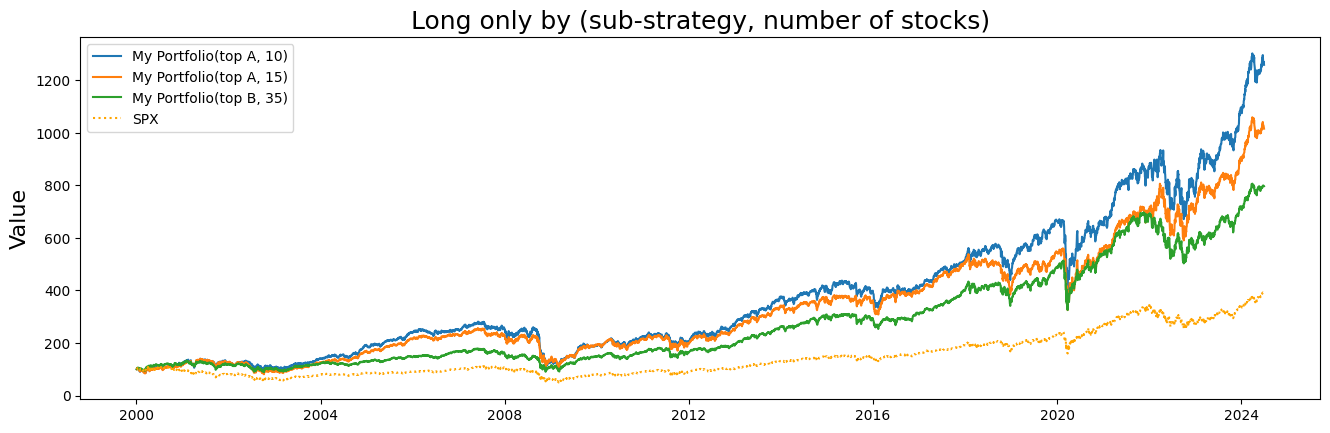

In [88]:
my_pf_longtop1 = long_pf_combined[(long_pf_combined.index.get_level_values(0) == 'A') &(long_pf_combined.index.get_level_values(1) == 10) ].droplevel([0, 1])
my_pf_longtop2 = long_pf_combined[(long_pf_combined.index.get_level_values(0) == 'A') &(long_pf_combined.index.get_level_values(1) == 15) ].droplevel([0, 1])
my_pf_longtop3 = long_pf_combined[(long_pf_combined.index.get_level_values(0) == 'B') &(long_pf_combined.index.get_level_values(1) == 35) ].droplevel([0, 1])

plt.figure(figsize=(16, 16))
plt.subplot(3,1,1)
plt.title('Long only by (sub-strategy, number of stocks)',fontsize=18)
plt.ylabel('Value', fontsize = 16)
plt.plot(my_pf_longtop1, label = 'My Portfolio(top A, 10)')
plt.plot(my_pf_longtop2, label = 'My Portfolio(top A, 15)')
plt.plot(my_pf_longtop3, label = 'My Portfolio(top B, 35)')
plt.plot(spx, color = 'orange', linestyle = ':',label = 'SPX')
plt.legend(loc = 'best')
plt.show()

## Step5-2: Sensitivity analysis of Short only

In [98]:
short_pf = []
short_results = []
for how_many in tqdm(range(5, 55, 5)):
    for strat in ['A', 'B', 'C']:
        my_pf_shortbottom, my_result_shortbottom = backtest_shortonly_bottom(daily_price, strat, 100, 0.005, how_many)

        my_pf_shortbottom.columns = ['shortbottom_Value']
        my_pf_shortbottom['How_Many'] = how_many
        my_pf_shortbottom['Strategy'] = strat

        my_result_shortbottom['How_Many'] = how_many
        my_result_shortbottom['Strategy'] = strat

        short_pf.append(my_pf_shortbottom)
        short_results.append(my_result_shortbottom)

short_pf_combined = (
    pd.concat(short_pf, axis=0)
    .reset_index()
    .rename(columns={'index':'Date'})
    .set_index(['Strategy','How_Many', 'Date'])
)
short_results_combined = (
    pd.concat(short_results)
    .reset_index()
    .rename(columns={'index':'Metrics'})
    .set_index(['Strategy','How_Many', 'Metrics'])
)

short_max_sharpe = short_results_combined.unstack(level=2)
short_max_sharpe.columns = short_max_sharpe.columns.droplevel(0)
short_max_sharpe = short_max_sharpe.sort_values(by='Cumulative_Return', ascending=False).filter(['Annual_Sharpe', 'Annual_Return', 'Annunal_Std', 'Cumulative_Return'])

short_pf_combined.to_pickle('short_pf_combined.pickle')
short_results_combined.to_pickle('short_results_combined.pickle')
short_max_sharpe.to_pickle('short_max_sharpe.pickle')


100%|██████████| 10/10 [05:43<00:00, 34.32s/it]


## Step5-2: Results
For the short strategy, the cumulative returns are negative across all scenarios. While there are some periods of success, such as during the global financial crisis, the portfolio value declines for most of the time.  
Listed in order of highest cumulative return.

In [99]:
short_max_sharpe.to_excel("short_max_sharpe.xlsx")
short_max_sharpe.head(10)

Annual_Sharpe  Annual_Return  Annunal_Std  \
Strategy How_Many                                              
C        5                   NaN            NaN    10.746089   
         10                  NaN            NaN     4.151025   
         15                  NaN            NaN     1.263293   
B        15                  NaN            NaN    21.391217   
         20                  NaN            NaN     3.772894   
C        20                  NaN            NaN    12.394340   
B        25                  NaN            NaN     7.887567   
C        25                  NaN            NaN    93.479738   
B        10                  NaN            NaN     4.062763   
         30                  NaN            NaN     3.635897   

                   Cumulative_Return  
Strategy How_Many                     
C        5                 -1.924503  
         10                -1.938052  
         15                -2.082952  
B        15                -2.117038  
         20                -2.230760  
C        20                -2.295877  
B        25                -2.334681  
C        25                -2.343069  
B        10                -2.413051  
         30                -2.416610

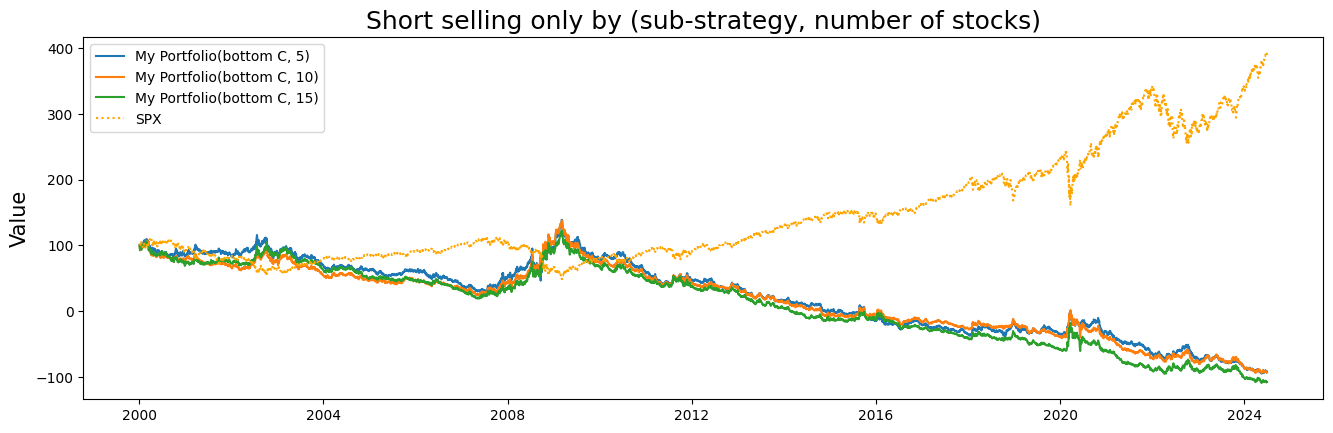

In [100]:
my_pf_shortbottom1 = short_pf_combined[(short_pf_combined.index.get_level_values(0) == 'C') &(short_pf_combined.index.get_level_values(1) == 5) ].droplevel([0, 1])
my_pf_shortbottom2 = short_pf_combined[(short_pf_combined.index.get_level_values(0) == 'C') &(short_pf_combined.index.get_level_values(1) == 10) ].droplevel([0, 1])
my_pf_shortbottom3 = short_pf_combined[(short_pf_combined.index.get_level_values(0) == 'C') &(short_pf_combined.index.get_level_values(1) == 15) ].droplevel([0, 1])

plt.figure(figsize=(16, 16))
plt.subplot(3,1,1)
plt.title('Short selling only by (sub-strategy, number of stocks)',fontsize=18)
plt.ylabel('Value', fontsize = 15)
plt.plot(my_pf_shortbottom1, label = 'My Portfolio(bottom C, 5)')
plt.plot(my_pf_shortbottom2, label = 'My Portfolio(bottom C, 10)')
plt.plot(my_pf_shortbottom3, label = 'My Portfolio(bottom C, 15)')
plt.plot(spx, color = 'orange', linestyle = ':', label = 'SPX')
plt.legend(loc = 'best')
plt.show()

## Step5-3: Sensitivity analysis of Long-Short only

In [101]:
ls_pf = []
ls_results = []
for how_many in tqdm(range(5, 55, 5)):
    for lstrat in ['A', 'B', 'C']:
        for sstrat in ['A', 'B', 'C']:
            my_pf_ls, my_result_ls = backtest_longshort(daily_price, lstrat, sstrat, 100, 0.005, how_many)

            my_pf_ls.columns = ['ls_Value']
            my_pf_ls['How_Many'] = how_many
            my_pf_ls['LStrategy'] = lstrat
            my_pf_ls['SStrategy'] = sstrat

            my_result_ls['How_Many'] = how_many
            my_result_ls['LStrategy'] = lstrat
            my_result_ls['SStrategy'] = sstrat

            ls_pf.append(my_pf_ls)
            ls_results.append(my_result_ls)

ls_pf_combined = (
    pd.concat(ls_pf, axis=0)
    .reset_index()
    .rename(columns={'index':'Date'})
    .set_index(['LStrategy','SStrategy','How_Many', 'Date'])
)
ls_results_combined = (
    pd.concat(ls_results)
    .reset_index()
    .rename(columns={'index':'Metrics'})
    .set_index(['LStrategy', 'SStrategy','How_Many', 'Metrics'])
)

ls_max_sharpe = ls_results_combined.unstack(level=3)
ls_max_sharpe.columns = ls_max_sharpe.columns.droplevel(0)
ls_max_sharpe = ls_max_sharpe.sort_values(by='Annual_Sharpe', ascending=False).filter(['Annual_Sharpe', 'Annual_Return', 'Annunal_Std', 'Cumulative_Return'])

ls_pf_combined.to_pickle('ls_pf_combined.pickle')
ls_results_combined.to_pickle('ls_results_combined.pickle')
ls_max_sharpe.to_pickle('ls_max_sharpe.pickle')


100%|██████████| 10/10 [35:48<00:00, 214.89s/it]


In [118]:
ls_max_sharpe.to_excel("ls_max_sharpe.xlsx")
ls_max_sharpe.head(10)

Annual_Sharpe  Annual_Return  Annunal_Std  \
LStrategy SStrategy How_Many                                              
A         C         10             0.440775       0.101388     0.230022   
          B         15             0.419445       0.088824     0.211766   
                    10             0.418580       0.099339     0.237324   
                    20             0.415526       0.086807     0.208909   
          C         15             0.401377       0.089012     0.221767   
                    20             0.395392       0.086430     0.218592   
          A         10             0.373912       0.099244     0.265422   
          B         40             0.366505       0.077497     0.211448   
          C         40             0.351195       0.077103     0.219544   
          B         45             0.347876       0.074828     0.215100   

                              Cumulative_Return  
LStrategy SStrategy How_Many                     
A         C         10                 9.653166  
          B         15                 7.042911  
                    10                 9.178168  
                    20                 6.685726  
          C         15                 7.076998  
                    20                 6.620609  
          A         10                 9.156701  
          B         40                 5.225143  
          C         40                 5.169603  
          B         45                 4.858157

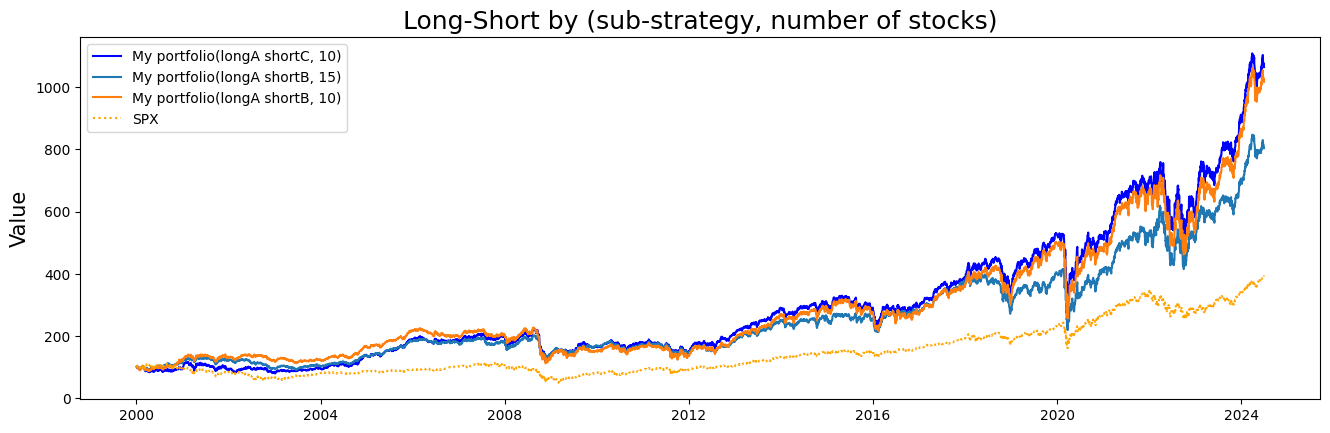

In [142]:
my_pf_ls1 = ls_pf_combined[(ls_pf_combined.index.get_level_values(0) == 'A') &(ls_pf_combined.index.get_level_values(1) == 'C') & (ls_pf_combined.index.get_level_values(2) == 10) ].droplevel([0, 1, 2])
my_pf_ls2 = ls_pf_combined[(ls_pf_combined.index.get_level_values(0) == 'A') &(ls_pf_combined.index.get_level_values(1) == 'B') & (ls_pf_combined.index.get_level_values(2) == 15) ].droplevel([0, 1, 2])
my_pf_ls3 = ls_pf_combined[(ls_pf_combined.index.get_level_values(0) == 'A') &(ls_pf_combined.index.get_level_values(1) == 'B') & (ls_pf_combined.index.get_level_values(2) == 10) ].droplevel([0, 1, 2])

# Compare Values between  strategies
plt.figure(figsize=(16, 16))
plt.subplot(3,1,1)
plt.title('Long-Short by (sub-strategy, number of stocks)',fontsize=18)
plt.ylabel('Value', fontsize = 15)
plt.plot(my_pf_ls1, color = 'b', label = 'My portfolio(longA shortC, 10)')
plt.plot(my_pf_ls2, label = 'My portfolio(longA shortB, 15)')
plt.plot(my_pf_ls3, label = 'My portfolio(longA shortB, 10)')
plt.plot(spx, color = 'orange', linestyle = ':', label = 'SPX')
plt.legend(loc = 'best')
plt.show()

# Step6: Summary

The long strategy and long-short strategy, tested with the optimal parameters, outperform the SPX. The performance for each is as follows.  

In [170]:

def pf_performance(my_pf , spx, date_lst = ['2000-01-04','2024-06-30']) :

    # date_lst = ['2009-10-01','2020-10-01']
    my_pf = my_pf[pd.to_datetime(date_lst[0], format="%Y-%m-%d") : pd.to_datetime(date_lst[1], format="%Y-%m-%d")]

    spx = spx[pd.to_datetime(date_lst[0], format="%Y-%m-%d") : pd.to_datetime(date_lst[1], format="%Y-%m-%d")]

    monthly_value = pd.concat([my_pf,spx] ,axis = 1)
    # if my_pf.index[0] == my_pf.resample('M').last().index[0] :
    #     monthly_value = pd.concat([my_pf.resample('M').last() , spx['SPX_Value'].resample('M').last()], axis = 1).dropna()
    # else :
    #     a = pd.concat([my_pf.iloc[[0]],my_pf.resample('M').last()] ,axis = 0)
    #     monthly_value = pd.concat([ a,spx['SPX_Value'].resample('M').last()   ], axis = 1).dropna()
    my_index = my_pf.columns[0]
    Draw_Down = -((monthly_value[my_index].rolling(252).max()- monthly_value[my_index])/monthly_value[my_index].rolling(252).max())
    MDD = round(abs(Draw_Down.min()), 4)

    T_N = (my_pf.index[-1]- my_pf.index[0]).days/365
    Annual_Return = ((my_pf[my_index].iloc[-1]/my_pf[my_index].iloc[0]) ** (1/T_N) -1 )
    Annual_Stdev = (monthly_value[my_index].pct_change().std() * np.sqrt(252))
    Sharp = ((Annual_Return )/Annual_Stdev)
    initial = my_pf[my_index].iloc[0].round(1)
    final = my_pf[my_index].iloc[-1].round(1)


    yearly_value = pd.concat([my_pf.iloc[[0]], my_pf.resample('Y').last()], axis = 0 )

    Best_Year , Worst_Year = yearly_value.pct_change()[my_index].idxmax().year, yearly_value.pct_change()[my_index].idxmin().year
    Mkt_Corr = monthly_value.pct_change().corr()[my_index]['SPX_Value'].round(4)
    result_data = pd.DataFrame([initial, final, Annual_Return.round(4), Annual_Stdev.round(4), MDD,Sharp.round(4), str(Best_Year), str(Worst_Year), Mkt_Corr],index = ['Initial Value', 'Final Value','Annual Return', 'Annual Stdev', 'MDD','Sharp Ratio','Best Year', 'Worst Year','Market Corr'], columns = [str(my_pf.index[0])[:7] + ' ~ ' + str(my_pf.index[-1])[:7]]).T

    return Draw_Down, result_data


def port_analyze(my_pf , spx, date_lst = ['2000-01-04','2024-06-30'], name="Long"):

    MA_Year = 1
    MA_months  = 12 * MA_Year

    Draw_Down, result_data = pf_performance(my_pf , spx, date_lst)
    my_index = my_pf.columns[0]

    monthly_value = my_pf.resample('M').last()[my_index]
    monthly_kospi_value = spx['SPX_Value'].resample('M').last()
    monthly_return = monthly_value.pct_change()
    monthly_kospi_return = monthly_kospi_value.pct_change()
    mkt_rolling_return = ((monthly_kospi_value/monthly_kospi_value.shift(MA_months))) ** (1/MA_Year)-1

    sigma_mkt = monthly_kospi_return.rolling(MA_months).std() * np.sqrt(12)
    mkt_sharp = mkt_rolling_return/sigma_mkt

    sigma= monthly_return.rolling(MA_months).std() * np.sqrt(12)
    rolling_return = ((monthly_value/monthly_value.shift(MA_months))) ** (1/MA_Year)-1
    #r_minus_rf = rolling_return - rf
    sharp = rolling_return/sigma
    sharp.name='Sharpe'


    date_name = [
        pd.to_datetime('20000101', format="%Y%m%d"),
        pd.to_datetime('20091001', format="%Y%m%d"), # GFC
        pd.to_datetime('20200901', format="%Y%m%d"), # Covid-19
        pd.to_datetime('20240630', format="%Y%m%d"),
        ]

    real_name_lst = []
    df2 = pd.DataFrame()
    for i in range(len(date_name)-1) :
        d1 = sharp.to_frame()[date_name[i]:date_name[i+1]]
        series = pd.Series(d1[d1.columns[0]].mean(), index = d1.index)
        series.name = 'Average : '+str(d1.index[0])[:7] + ' to ' +str(d1.index[-1])[:7]
        real_name_lst.append('Average : '+str(d1.index[0])[:7] + ' to ' +str(d1.index[-1])[:7])
        df2 = pd.concat([df2, series], axis = 1)

    plt.figure(figsize = (16,18))
    plt.subplot(4,1,1)
    plt.title('Portfolio Value / ' + str(name) ,fontsize=18)
    plt.ylabel('Value',fontsize=16)
    plt.plot(my_pf[my_index], color = 'b' , label = 'My Portfolio')
    plt.plot(spx['SPX_Value'], color = 'orange' ,label = 'SPX')
    plt.legend(loc = 'best')

    plt.figure(figsize=(16,18))
    plt.subplot(6,1,4)
    plt.title('12M Moving Average Return / ' + str(name),fontsize=18)
    plt.ylabel('MA return',fontsize=16)
    plt.plot(rolling_return, label = 'My Portfolio ', color = 'b' , linestyle = '--')
    plt.plot(mkt_rolling_return, label = 'SPX ' , color = 'orange', linestyle = ':')
    plt.plot(pd.Series([0]*len(rolling_return) , index = rolling_return.index), color = 'grey', alpha=0.5)
    plt.legend(loc = 'best')

    plt.figure(figsize = (16,18))
    plt.subplot(4,1,1)
    plt.title('12M Moving Average Sharpe Ratio / ' + str(name), fontsize=18)
    plt.ylabel('MA sharpe', fontsize= 16)
    plt.yticks(np.arange(-2,5,0.5))
    plt.plot(sharp ,color = 'blue',  label = 'My portfolio')
    plt.plot(mkt_sharp, color = 'orange', label = 'SPX')
    plt.plot(pd.Series([0]*len(sharp), index = sharp.index),color = 'grey' ,alpha = 0.5 )
    for i in real_name_lst :
        plt.plot(df2[i], label = i , linestyle = ':')
    plt.legend(loc = 'best')
    plt.show()

    plt.figure(figsize=(16,18))
    plt.subplot(4,1,1)
    plt.title('Draw Down for 12M / ' + str(name), fontsize= 18)
    plt.ylabel('Draw Down',fontsize=16)
    plt.plot(Draw_Down, color = 'black', label = 'Draw_Down')
    plt.legend(loc = 'best')


## Step6-1: Performance of Long only Strategy

Initial Value: Initial portfolio value  
Final Value: Portfolio value at the end of the period  
Annual Return: Compound annual growth rate (CAGR)  
Annual Stdev: Annual volatility  
MDD: MDD stands for Maximum Drawdown, (here during 1 year)which represents the largest peak-to-trough decline in the value of an investment asset. It is a metric that measures how much the value dropped from its highest point to its lowest point, expressed as a percentage. MDD helps identify when a strategy underperformed and how much the asset declined during its worst period.
Sharpe Ratio: Risk-adjusted return  
Best Year: Year with the highest return  
Worst Year: Year with the lowest return  
Market Corr: Correlation with the market index  

In [160]:
pf_performance(my_pf_longtop1, spx)[1]

,Initial Value,Final Value,Annual Return,Annual Stdev,MDD,Sharp Ratio,Best Year,Worst Year,Market Corr
2000-01 ~ 2024-06,100.0,1259.1,0.1089,0.2365,0.6211,0.4606,2019,2008,0.8857


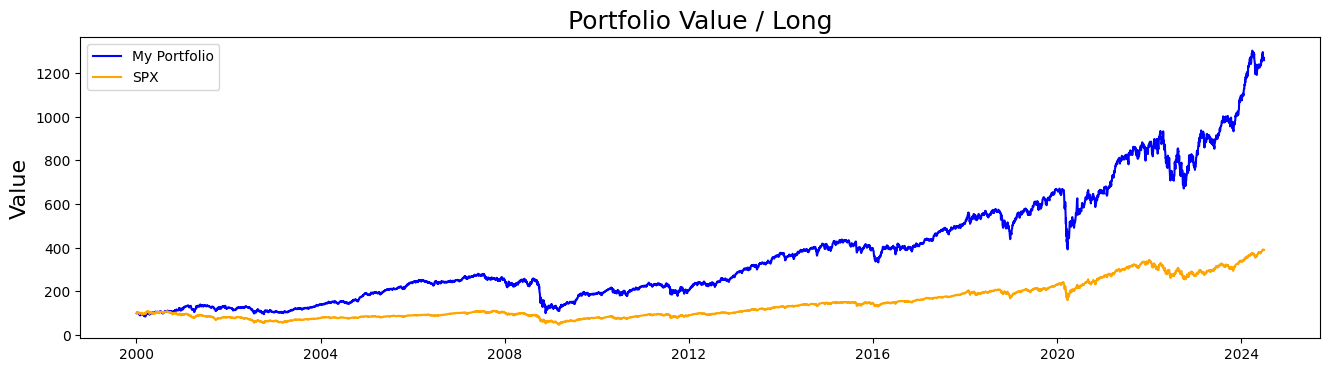

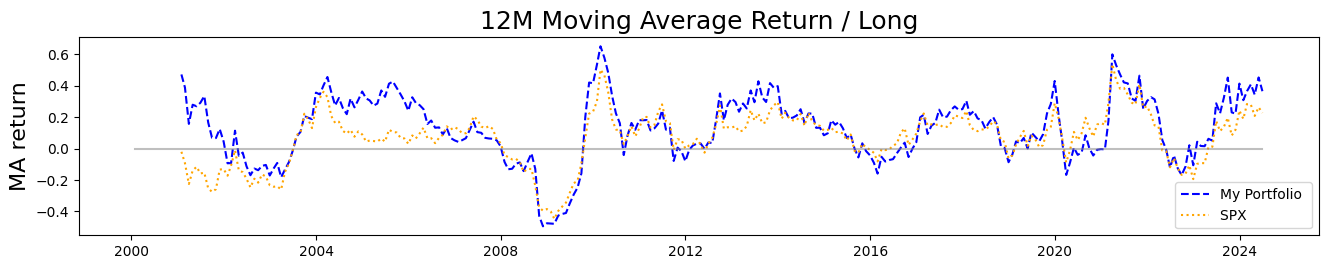

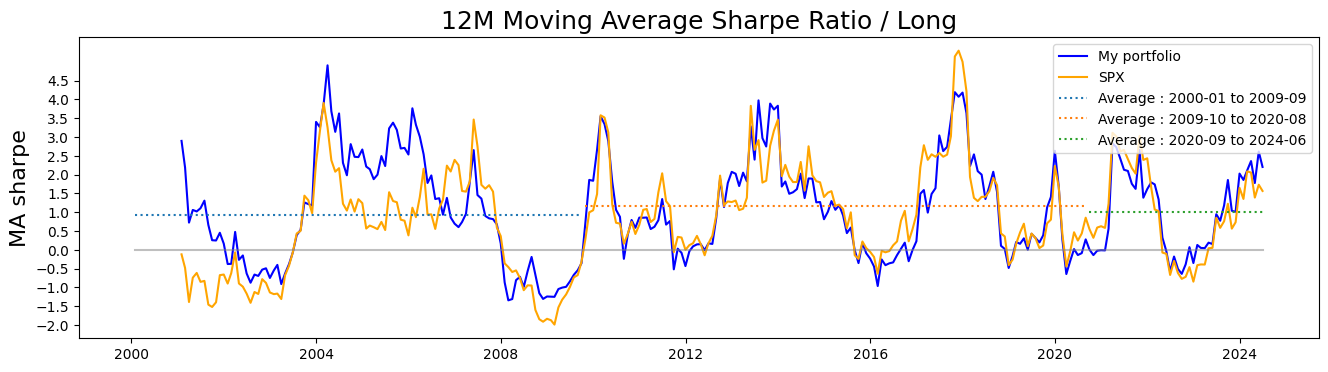

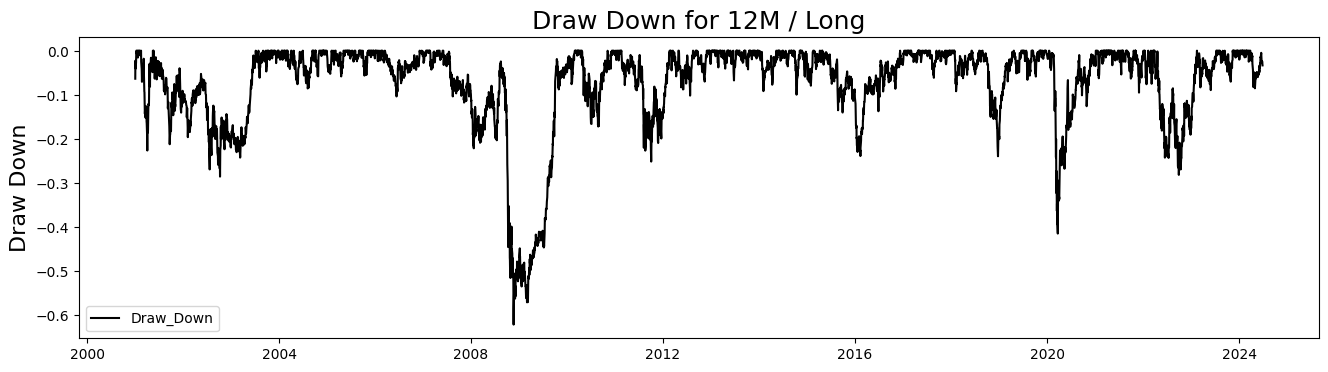

In [171]:
port_analyze(my_pf_longtop1 , spx,  name= "Long")

## Step6-2: Performance of Long-Short Strategy


In [163]:
pf_performance(my_pf_ls1, spx)[1]

,Initial Value,Final Value,Annual Return,Annual Stdev,MDD,Sharp Ratio,Best Year,Worst Year,Market Corr
2000-01 ~ 2024-06,100.0,1065.3,0.1014,0.23,0.4743,0.4408,2023,2008,0.6788


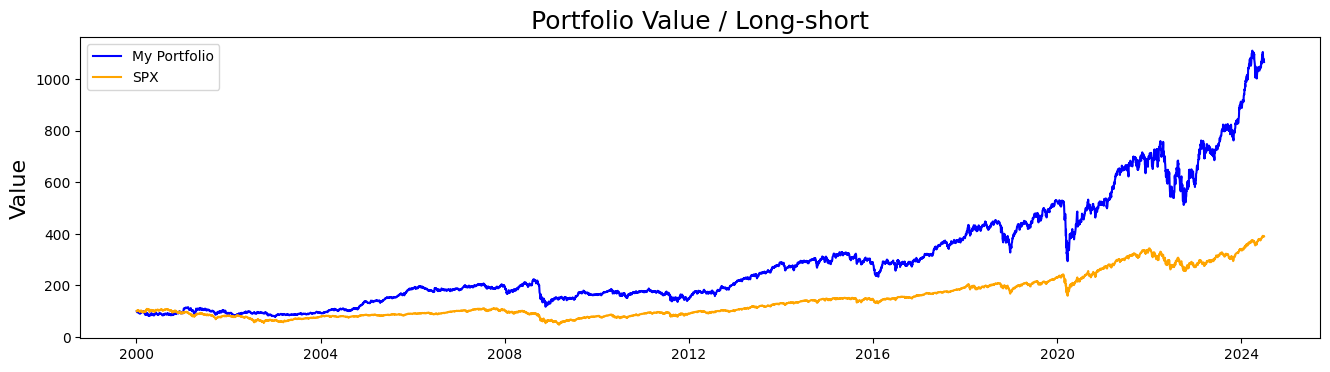

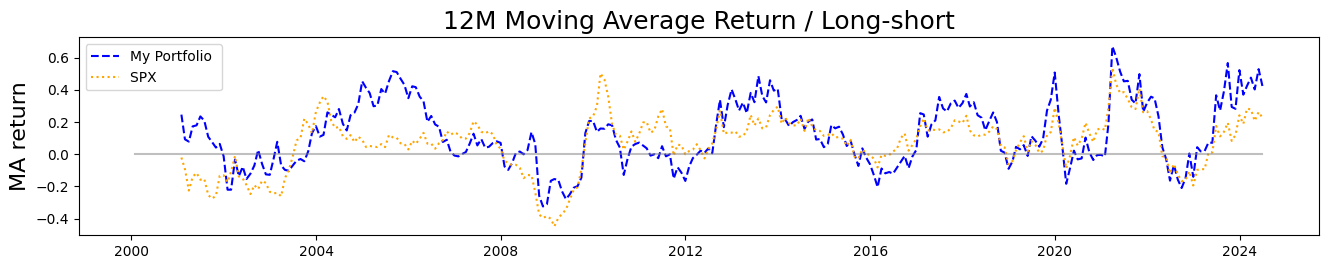

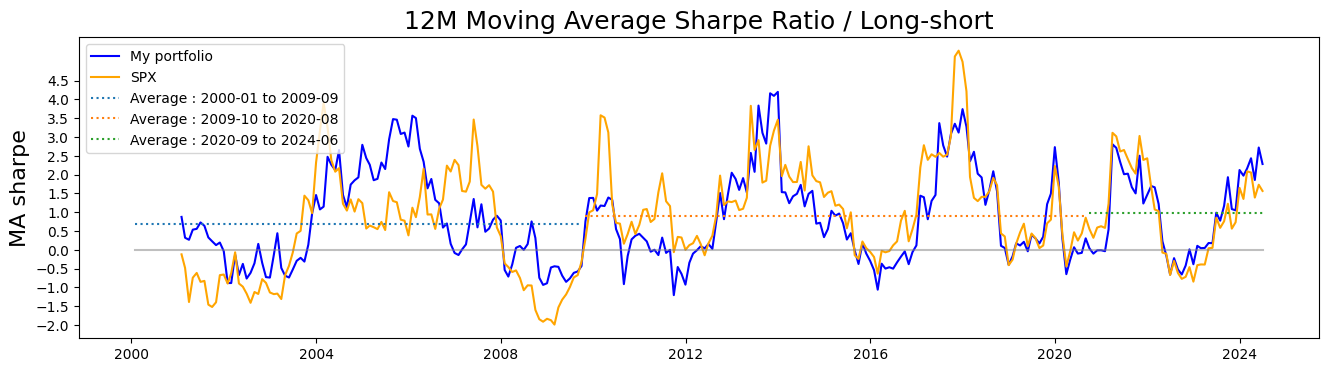

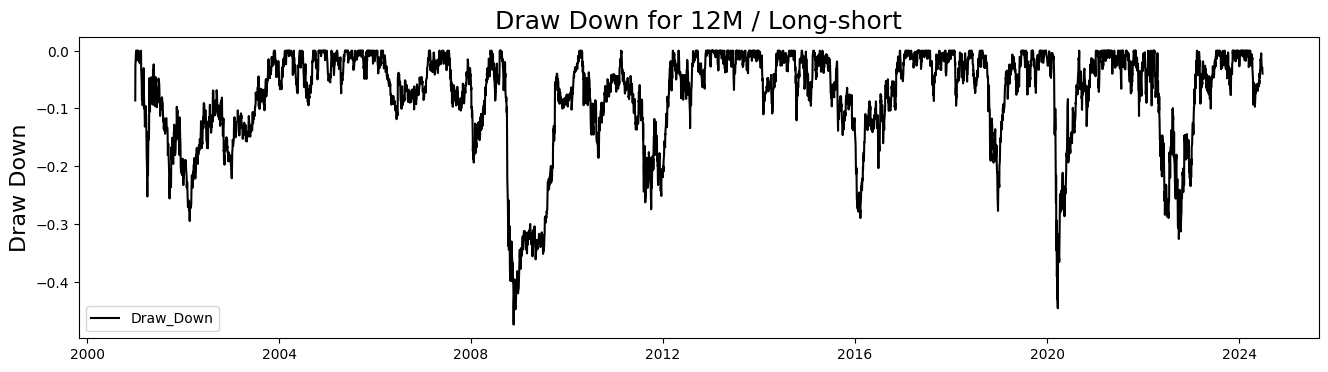

In [173]:
port_analyze(my_pf_ls1 , spx, name= "Long-short")

## Summary

Although the portfolio value is high, the annual return and Sharpe ratio do not show significant differences compared to the index.  
The MDD highlights that the Global Financial Crisis was the point of the biggest failure in our strategy.   
Given that the average Sharpe ratio did not show much difference before and after regime changes such as the GFC and Covid-19, we can say that the strategy operates similarly across most periods.

# Step7: Retriction and Conclusion (To be Confirmed)



To eliminate survivorship bias, a common mistake in investment strategy analysis, we downloaded the list of delisted companies along with their historical stock prices to enhance the effectiveness of the strategy.

However, there is still bias present. In our rebalancing and trading timings, we used information(Factors) that would not have been available at the time, which introduces a look-ahead bias in the backtesting.